In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from __future__ import division
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
from sklearn.model_selection import KFold

In [4]:
df = pd.read_csv('dataset/creditcard.csv')
df_fe = df.drop(['V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28'], axis =1)

In [5]:
count_normal_transacation = len(df_fe[df_fe["Class"]==0]) # normal transaction are repersented by 0
count_fraud_transacation = len(df_fe[df_fe["Class"]==1]) # fraud by 1
fraud_indices = np.array(df_fe[df_fe.Class==1].index)
normal_indices = np.array(df_fe[df_fe.Class==0].index)

#now let us a define a function for make undersample data with different proportion
#different proportion means with different proportion of normal classes of data

def undersample(df, normal_indices, fraud_indices, multiple): # multiple denote the normal data = multiple * fraud data
    normal_indices_undersample = np.array(np.random.choice(normal_indices,(multiple*count_fraud_transacation),replace=False))
    undersample_data = np.concatenate([fraud_indices, normal_indices_undersample])
    undersample_data = df.iloc[undersample_data,:]
    
    print "the normal transacation proportion is :", len(undersample_data[undersample_data.Class==0])/len(undersample_data)
    print "the fraud transacation proportion is :", len(undersample_data[undersample_data.Class==1])/len(undersample_data)
    print "total number of record in resampled data is:",len(undersample_data)
    return(undersample_data)

In [6]:
def prediction_algorithms(model, features_train, features_test, labels_train, labels_test):
    model.fit(features_train, labels_train.values.ravel())
    pred = model.predict(features_test)
    cm = confusion_matrix(labels_test,pred)
    recall = cm[1,1] / (cm[1,1] + cm[1,0])
    precision = cm[1,1] / (cm[1,1] + cm[0,1])
    print "the recall for this model is :", recall
    print "The accuracy is :", (cm[1,1]+cm[0,0])/(cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])
    loss = (1 - precision) * 88.29 + (1 - recall) * 122.12
    fig= plt.figure(figsize=(6,3))# to plot the graph
    print "TP",cm[1,1] # no of fraud transaction which are predicted fraud
    print "TN",cm[0,0] # no. of normal transaction which are predited normal
    print "FP",cm[0,1] # no of normal transaction which are predicted fraud
    print "FN",cm[1,0] # no of fraud Transaction which are predicted normal
    sns.heatmap(cm, cmap="coolwarm_r", annot=True, linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print "Classification Report:" 
    print(classification_report(labels_test,pred))
    print "The loss is : ", loss

In [7]:
def custom_loss_fuction(model,features_train,features_test,labels_train,labels_test):
    model.fit(features_train,labels_train.values.ravel())
    pred = model.predict(features_test)
    cm = confusion_matrix(labels_test,pred)
    recall = cm[1,1] / (cm[1,1] + cm[1,0])
    precision = cm[1,1] / (cm[1,1] + cm[0,1])
    loss = (1 - precision) * 88.29 + (1 - recall) * 122.12
    return loss

## Tuning hyperparameters using custom grid-search like methods with 5-fold cv
***

### Logistic Regression 
#### C, penalty
***

In [10]:
undersample_data_lr = undersample(df, normal_indices,fraud_indices, 132)
X_undersample_lr = undersample_data_lr.iloc[:, undersample_data_lr.columns != "Class"]
y_undersample_lr = undersample_data_lr.iloc[:, undersample_data_lr.columns == "Class"]
X_undersample_train_lr, X_undersample_test_lr, y_undersample_train_lr, y_undersample_test_lr = train_test_split(X_undersample_lr, y_undersample_lr, random_state=0)
X_test_lr = df.iloc[:, df.columns != "Class"]
y_test_lr = df.iloc[:, df.columns == "Class"]

the normal transacation proportion is : 0.992481203008
the fraud transacation proportion is : 0.00751879699248
total number of record in resampled data is: 65436


In [39]:
def Kfold_tuning_lr(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    c_param_range = [0.01, 0.1, 1, 10, 100]
    penalties = ['l1', 'l2']

    penalty_list = []
    c_list = []
    mean_loss_list = []
    
    j = 0
    for penalty in penalties:
        print '-------------------------------------------'
        print 'Penalty: ', penalty 
        print '-------------------------------------------'
        for c_param in c_param_range:
            print '-------------------------------------------'
            print 'C parameter: ', c_param
            print '-------------------------------------------'
            print ''

            loss_list = []
            for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

                # Call the logistic regression model with a certain C parameter
                lr = LogisticRegression(C=c_param, penalty=penalty, random_state=0)

                # Calculate the custom loss and append it to a list for loss representing the current c_parameter
                loss = custom_loss_fuction(lr, X_train_data.iloc[train], X_test_lr, y_train_data.iloc[train], y_test_lr)
                loss_list.append(loss)
                print 'Fold ', k + 1,': loss = ', loss

            j += 1
            print ''
            print 'Mean loss', np.mean(loss_list)
            print ''
            penalty_list.append(penalty)
            c_list.append(c_param)
            mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['Penalty', 'C_parameter','Mean loss'])
    results_table['Penalty'] = penalty_list
    results_table['C_parameter'] = c_list
    results_table['Mean loss'] = mean_loss_list
        
    best_penalty = results_table.loc[results_table['Mean loss'].idxmin()]['Penalty']
    best_c = results_table.loc[results_table['Mean loss'].idxmin()]['C_parameter']
    
    print results_table
    print  ''
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print '************************************************************************************'
    print 'Best model to choose from cross validation is with Penalty = ', best_penalty, 'and best c = ', best_c
    print '************************************************************************************'
    
    return Kfold_tuning_lr

In [32]:
best_parameters_lr = Kfold_tuning_lr(X_undersample_train_lr, y_undersample_train_lr)

-------------------------------------------
Penalty:  l1
-------------------------------------------
-------------------------------------------
C parameter:  0.01
-------------------------------------------

Fold  1 : loss =  53.9483650214455
Fold  2 : loss =  52.65091625389262
Fold  3 : loss =  57.74639690574804
Fold  4 : loss =  48.910385234659195
Fold  5 : loss =  54.14612608010897

Mean loss 53.480437899170866

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Fold  1 : loss =  47.04657095811464
Fold  2 : loss =  44.0415245164874
Fold  3 : loss =  49.02915595294782
Fold  4 : loss =  42.90277155937892
Fold  5 : loss =  45.891759863072316

Mean loss 45.78235657000022

-------------------------------------------
C parameter:  1
-------------------------------------------

Fold  1 : loss =  45.60606135136982
Fold  2 : loss =  44.19271843371496
Fold  3 : loss =  47.17284500840745
Fold  4 : loss =  43.7158150886627
Fold  5 : loss 

#### Optimal Logistic Regression Model
Since C=10 and C=100 have very similar results, we will simply use C=10.
* C=10, penalty=l1
***

the model classification for 132 proportion
the recall for this model is : 0.806910569105691
The accuracy is : 0.9993012812185094
TP 397
TN 284211
FP 104
FN 95


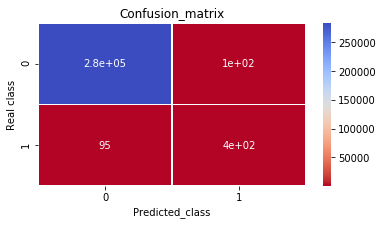

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.79      0.81      0.80       492

avg / total       1.00      1.00      1.00    284807

The loss is :  41.9077459714717


In [11]:
print "the model classification for 132 proportion"
optimal_lr = LogisticRegression(C=10, penalty='l1', random_state=0)
prediction_algorithms(optimal_lr, X_undersample_train_lr, X_test_lr, y_undersample_train_lr, y_test_lr)

### Support Vector Machine (kernel='rbf')
#### C, gamma

In [42]:
undersample_data_svm = undersample(df_fe, normal_indices,fraud_indices, 8)
X_undersample_svm = undersample_data_svm.iloc[:, undersample_data_svm.columns != "Class"]
y_undersample_svm = undersample_data_svm.iloc[:, undersample_data_svm.columns == "Class"]
X_undersample_train_svm, X_undersample_test_svm, y_undersample_train_svm, y_undersample_test_svm = train_test_split(X_undersample_svm, y_undersample_svm, random_state=0)
X_test_svm = df_fe.iloc[:, df_fe.columns != "Class"]
y_test_svm = df_fe.iloc[:, df_fe.columns == "Class"]

the normal transacation proportion is : 0.888888888889
the fraud transacation proportion is : 0.111111111111
total number of record in resampled data is: 4428


In [43]:
def Kfold_tuning_svm(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    c_param_range = [0.1, 1, 2, 5]
    gamma_range = [0.01, 0.1, 'auto', 1]

    c_list = []
    gamma_list = []
    mean_loss_list = []
    
    j = 0
    for c_param in c_param_range:
        print '-------------------------------------------'
        print 'C parameter: ', c_param
        print '-------------------------------------------'
        for gamma in gamma_range:
            print '-------------------------------------------'
            print 'Gamma: ', gamma
            print '-------------------------------------------'
            print ''

            loss_list = []
            for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

                # Call the logistic regression model with a certain C parameter
                svm = SVC(C=c_param, gamma=gamma, random_state=0)

                # Calculate the custom loss and append it to a list for loss representing the current c_parameter
                loss = custom_loss_fuction(svm, X_train_data.iloc[train], X_test_svm, y_train_data.iloc[train], y_test_svm)
                loss_list.append(loss)
                print 'Fold ', k + 1,': loss = ', loss

            j += 1
            print ''
            print 'Mean loss', np.mean(loss_list)
            print ''
            gamma_list.append(gamma)
            c_list.append(c_param)
            mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['C_parameter','Gamma', 'Mean loss'])
    results_table['Gamma'] = gamma_list
    results_table['C_parameter'] = c_list
    results_table['Mean loss'] = mean_loss_list
        
    best_gamma = results_table.loc[results_table['Mean loss'].idxmin()]['Gamma']
    best_c = results_table.loc[results_table['Mean loss'].idxmin()]['C_parameter']
    
    print results_table
    print  ''
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print '************************************************************************************'
    print 'Best model to choose from cross validation is with C = ', best_c, 'and best gamma = ', best_gamma
    print '************************************************************************************'
    
    return Kfold_tuning_svm

In [44]:
best_parameters_svm = Kfold_tuning_svm(X_undersample_train_svm, y_undersample_train_svm)

-------------------------------------------
C parameter:  0.1
-------------------------------------------
-------------------------------------------
Gamma:  0.01
-------------------------------------------



/Users/marcus/venv0/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


Fold  1 : loss =  nan
Fold  2 : loss =  nan
Fold  3 : loss =  nan
Fold  4 : loss =  nan
Fold  5 : loss =  nan

Mean loss nan

-------------------------------------------
Gamma:  0.1
-------------------------------------------

Fold  1 : loss =  nan
Fold  2 : loss =  nan
Fold  3 : loss =  nan
Fold  4 : loss =  nan
Fold  5 : loss =  nan

Mean loss nan

-------------------------------------------
Gamma:  auto
-------------------------------------------

Fold  1 : loss =  nan
Fold  2 : loss =  nan
Fold  3 : loss =  nan
Fold  4 : loss =  nan
Fold  5 : loss =  nan

Mean loss nan

-------------------------------------------
Gamma:  1
-------------------------------------------

Fold  1 : loss =  nan
Fold  2 : loss =  nan
Fold  3 : loss =  nan
Fold  4 : loss =  nan
Fold  5 : loss =  nan

Mean loss nan

-------------------------------------------
C parameter:  1
-------------------------------------------
-------------------------------------------
Gamma:  0.01
---------------------------------

#### Optimal SVM Model
* C = 1, gamma = 0.1
***

the model classification for 8 proportion
the recall for this model is : 0.7764227642276422
The accuracy is : 0.9996137735378695
TP 382
TN 284315
FP 0
FN 110


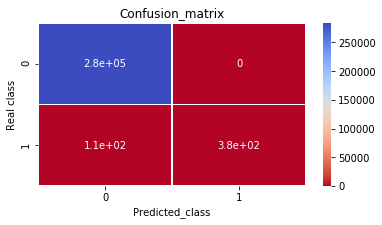

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       1.00      0.78      0.87       492

avg / total       1.00      1.00      1.00    284807

The loss is :  27.303252032520334


In [45]:
print "the model classification for 8 proportion"
optimal_svm = SVC(gamma=0.1, random_state=0)
prediction_algorithms(optimal_svm, X_undersample_train_svm, X_test_svm, y_undersample_train_svm, y_test_svm)

### Random Forest
#### n_estimators, max_features, max_depth
***

In [22]:
undersample_data_rf = undersample(df_fe, normal_indices,fraud_indices, 70)
X_undersample_rf = undersample_data_rf.iloc[:, undersample_data_rf.columns != "Class"]
y_undersample_rf = undersample_data_rf.iloc[:, undersample_data_rf.columns == "Class"]
X_undersample_train_rf, X_undersample_test_rf, y_undersample_train_rf, y_undersample_test_rf = train_test_split(X_undersample_rf, y_undersample_rf, random_state=0)
X_test_rf = df_fe.iloc[:, df_fe.columns != "Class"]
y_test_rf = df_fe.iloc[:, df_fe.columns == "Class"]

the normal transacation proportion is : 0.985915492958
the fraud transacation proportion is : 0.0140845070423
total number of record in resampled data is: 34932


In [23]:
def Kfold_tuning_rf(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    n_estimators_range = [10, 100, 150, 200]
    max_features_type = ['auto', 'log2']
    max_depth_range = [10, 20, 30, None]
    n_estimators_list = []
    max_features_list = []
    max_depth_list = []
    mean_loss_list = []

    j = 0
    for n_estimators in n_estimators_range:
        print '-------------------------------------------'
        print 'n_estimators: ', n_estimators
        print '-------------------------------------------'
        for max_features in max_features_type:
            print '-------------------------------------------'
            print 'max_features: ', max_features
            print '-------------------------------------------'
            for max_depth in max_depth_range:
                print '-------------------------------------------'
                print 'max_depth: ', max_depth
                print '-------------------------------------------'

                loss_list = []
                for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

                    rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, random_state=0)

                    loss = custom_loss_fuction(rf, X_train_data.iloc[train], X_test_rf, y_train_data.iloc[train], y_test_rf)
                    loss_list.append(loss)
                    print 'Fold ', k + 1,': loss = ', loss

                j += 1
                print ''
                print 'Mean loss', np.mean(loss_list)
                print ''
                n_estimators_list.append(n_estimators)
                max_features_list.append(max_features)
                max_depth_list.append(max_depth)
                mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['n_estimators', 'max_features', 'max_depth', 'Mean loss'])
    results_table['n_estimators'] = n_estimators_list
    results_table['max_features'] = max_features_list
    results_table['max_depth'] = max_depth_list
    results_table['Mean loss'] = mean_loss_list
        
    best_n_estimators = results_table.loc[results_table['Mean loss'].idxmin()]['n_estimators']
    best_max_features = results_table.loc[results_table['Mean loss'].idxmin()]['max_features']
    best_max_depth = results_table.loc[results_table['Mean loss'].idxmin()]['max_depth']
    
    print results_table
    print  ''
    
    print '**************************************************************************************************'
    print "Best model to choose from cross validation is with n_estimators = ", best_n_estimators, ", best max_features = ", best_max_features
    print "and best max_depth = ", best_max_depth
    print '**************************************************************************************************'
    
    return Kfold_tuning_rf

In [24]:
best_parameters_rf = Kfold_tuning_rf(X_undersample_train_rf, y_undersample_train_rf)

-------------------------------------------
n_estimators:  10
-------------------------------------------
-------------------------------------------
max_features:  auto
-------------------------------------------
-------------------------------------------
max_depth:  10
-------------------------------------------
Fold  1 : loss =  34.85760336591693
Fold  2 : loss =  34.436267868094546
Fold  3 : loss =  35.41204382082431
Fold  4 : loss =  34.85525294459907
Fold  5 : loss =  36.11754879630509

Mean loss 35.13574335914799

-------------------------------------------
max_depth:  20
-------------------------------------------
Fold  1 : loss =  26.09404973878636
Fold  2 : loss =  28.029842848707823
Fold  3 : loss =  31.03560449634071
Fold  4 : loss =  27.198434959349598
Fold  5 : loss =  29.006408624955817

Mean loss 28.27286813362806

-------------------------------------------
max_depth:  30
-------------------------------------------
Fold  1 : loss =  26.515741466488393
Fold  2 : loss =

Fold  1 : loss =  23.72494329377764
Fold  2 : loss =  24.627943694862477
Fold  3 : loss =  26.700390768423816
Fold  4 : loss =  21.954480416539404
Fold  5 : loss =  25.00811846689895

Mean loss 24.40317532810046

-------------------------------------------
n_estimators:  200
-------------------------------------------
-------------------------------------------
max_features:  auto
-------------------------------------------
-------------------------------------------
max_depth:  10
-------------------------------------------
Fold  1 : loss =  34.85525294459907
Fold  2 : loss =  33.86368826945413
Fold  3 : loss =  34.99338842326647
Fold  4 : loss =  35.130991587950554
Fold  5 : loss =  34.561018122013294

Mean loss 34.6808678694567

-------------------------------------------
max_depth:  20
-------------------------------------------
Fold  1 : loss =  23.448893259900345
Fold  2 : loss =  24.500318416150407
Fold  3 : loss =  26.443131543545647
Fold  4 : loss =  21.954480416539404
Fold  5

It seems tuning these 3 hyperparameters does nothing to the result. The optimal result is given by n_estimators=200, max_features='auto' and max_depth=20.
Since 200 is the upper bound of our n_estimators_list, more numbers larger than 200 need to be tested.
***

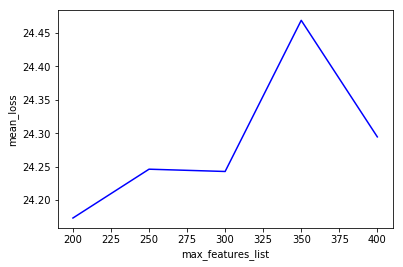

200 24.173480697029717


In [25]:
fold = KFold(n_splits=5, shuffle=False, random_state=0) 
mean_loss = []
max_features_list = []
for i in [200, 250, 300, 350, 400]:
    loss_list = []
    for k, (train, test) in enumerate(fold.split(X_undersample_train_rf, y_undersample_train_rf)):
        rf = RandomForestClassifier(n_estimators=i, max_depth=20, random_state=0)
        loss = custom_loss_fuction(rf, X_undersample_train_rf.iloc[train], X_test_rf, y_undersample_train_rf.iloc[train], y_test_rf)
        loss_list.append(loss)
    mean_loss.append(np.mean(loss_list))
    max_features_list.append(i)
plt.plot(max_features_list, mean_loss, '-b')
plt.ylabel('mean_loss')
plt.xlabel('max_features_list')
plt.show()

min_loss = np.min(mean_loss)
min_loss_index = mean_loss.index(min_loss)
optimal_max_features = max_features_list[min_loss_index]
print optimal_max_features, min_loss

It seems n_estimators=200 is still the optimal one.
Try out min_samples_split ,min_samples_leaf and other number of max_features.
***

In [26]:
def Kfold_tuning_rf1(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    max_features_range = ['auto', 1, 2, 8]
    min_samples_split_range = [2, 4, 8]
    min_samples_leaf_range = [1, 2, 4]

    max_features_list = []
    min_samples_split_list = []
    min_samples_leaf_list = []
    mean_loss_list = []

    j = 0
    for max_features in max_features_range:
        print '-------------------------------------------'
        print 'max_features: ', max_features
        print '-------------------------------------------'
        for min_samples_split in min_samples_split_range:
            print '-------------------------------------------'
            print 'min_samples_split: ', min_samples_split
            print '-------------------------------------------'
            for min_samples_leaf in min_samples_leaf_range:
                print '-------------------------------------------'
                print 'min_samples_leaf: ', min_samples_leaf
                print '-------------------------------------------'

                loss_list = []
                for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

                    rf = RandomForestClassifier(n_estimators=200, max_features=max_features, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_depth=20, random_state=0)

                    loss = custom_loss_fuction(rf, X_train_data.iloc[train], X_test_rf, y_train_data.iloc[train], y_test_rf)
                    loss_list.append(loss)
                    print 'Fold ', k + 1,': loss = ', loss

                j += 1
                print ''
                print 'Mean loss', np.mean(loss_list)
                print ''
                max_features_list.append(max_features)
                min_samples_split_list.append(min_samples_split)
                min_samples_leaf_list.append(min_samples_leaf)
                mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['max_features', 'min_samples_split', 'min_samples_leaf', 'Mean loss'])
    results_table['max_features'] = max_features_list
    results_table['min_samples_split'] = min_samples_split_list
    results_table['min_samples_leaf'] = min_samples_leaf_list
    results_table['Mean loss'] = mean_loss_list
        
    best_max_features = results_table.loc[results_table['Mean loss'].idxmin()]['max_features']
    best_min_samples_split = results_table.loc[results_table['Mean loss'].idxmin()]['min_samples_split']
    best_min_samples_leaf = results_table.loc[results_table['Mean loss'].idxmin()]['min_samples_leaf']
    
    print results_table
    print  ''
    
    print '**************************************************************************************************'
    print "Best model to choose from cross validation is with best max_features = ", best_max_features, ", best min_samples_split = ", best_min_samples_split
    print "and best min_samples_leaf = ", best_min_samples_leaf
    print '**************************************************************************************************'
    
    return Kfold_tuning_rf1

In [27]:
best_parameters_rf1 = Kfold_tuning_rf1(X_undersample_train_rf, y_undersample_train_rf)

-------------------------------------------
max_features:  auto
-------------------------------------------
-------------------------------------------
min_samples_split:  2
-------------------------------------------
-------------------------------------------
min_samples_leaf:  1
-------------------------------------------
Fold  1 : loss =  23.448893259900345
Fold  2 : loss =  24.500318416150407
Fold  3 : loss =  26.443131543545647
Fold  4 : loss =  21.954480416539404
Fold  5 : loss =  24.520579849012776

Mean loss 24.173480697029717

-------------------------------------------
min_samples_leaf:  2
-------------------------------------------
Fold  1 : loss =  34.436267868094546
Fold  2 : loss =  34.801907818326306
Fold  3 : loss =  36.093168089042265
Fold  4 : loss =  33.87601062079986
Fold  5 : loss =  35.515110402808574

Mean loss 34.94449295981431

-------------------------------------------
min_samples_leaf:  4
-------------------------------------------
Fold  1 : loss =  36.8192

Fold  5 : loss =  26.233588635886363

Mean loss 26.015777386462343

-------------------------------------------
min_samples_leaf:  2
-------------------------------------------
Fold  1 : loss =  35.693214038477024
Fold  2 : loss =  34.294465805834534
Fold  3 : loss =  34.26784528503968
Fold  4 : loss =  33.44392793572906
Fold  5 : loss =  33.587560815568786

Mean loss 34.257402776129815

-------------------------------------------
min_samples_leaf:  4
-------------------------------------------
Fold  1 : loss =  36.351321138211375
Fold  2 : loss =  35.973339140534264
Fold  3 : loss =  37.189534141353676
Fold  4 : loss =  35.21757268424611
Fold  5 : loss =  35.77454224827382

Mean loss 36.10126187052384

-------------------------------------------
min_samples_split:  8
-------------------------------------------
-------------------------------------------
min_samples_leaf:  1
-------------------------------------------
Fold  1 : loss =  34.26784528503968
Fold  2 : loss =  34.71658205709

* optimal max_features = 1, the values smaller than 1 will not be discussed here anymore. the optimal min_samples_split and min_samples_leaf are all default value.
***

#### Optimal Random Forest Model
* n_estimators=200, max_features=1, max_depth=20; min_samples_split and min_samples_leaf equals to default value.
***

the model classification for 70 proportion
the recall for this model is : 0.943089430894309
The accuracy is : 0.9996348404358039
TP 464
TN 284239
FP 76
FN 28


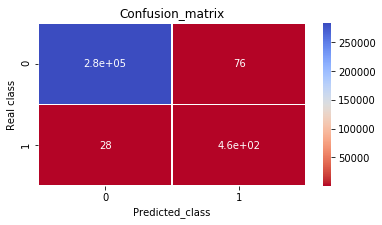

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.86      0.94      0.90       492

avg / total       1.00      1.00      1.00    284807

The loss is :  19.37591869918699


In [49]:
print "the model classification for 70 proportion"
optimal_rf = RandomForestClassifier(n_estimators=200, max_features=1, max_depth=20, random_state=0)
prediction_algorithms(optimal_rf, X_undersample_train_rf, X_test_rf, y_undersample_train_rf, y_test_rf)

### Gradient Boosting Tree
***

In [50]:
df_gbt = df.loc[:, ['V11', 'V17', 'V14', 'V10', 'V12', 'V4', 'Class']]
undersample_data_gbt = undersample(df_gbt, normal_indices,fraud_indices, 116)
X_undersample_gbt = undersample_data_gbt.iloc[:, undersample_data_gbt.columns != "Class"]
y_undersample_gbt = undersample_data_gbt.iloc[:, undersample_data_gbt.columns == "Class"]
X_undersample_train_gbt, X_undersample_test_gbt, y_undersample_train_gbt, y_undersample_test_gbt = train_test_split(X_undersample_gbt, y_undersample_gbt, random_state=0)
X_test_gbt = df_gbt.iloc[:, df_gbt.columns != "Class"]
y_test_gbt = df_gbt.iloc[:, df_gbt.columns == "Class"]

the normal transacation proportion is : 0.991452991453
the fraud transacation proportion is : 0.00854700854701
total number of record in resampled data is: 57564


#### Fixed learning rate, tuning n_estimators, max_depth, min_samples_split
***

In [51]:
def Kfold_tuning_gbt(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    n_estimators_range = [100, 200, 300]
    max_depth_range = [3, 5, 7, 9]
    min_samples_split_range = [2, 4, 8, 16]
    n_estimators_list = []
    max_depth_list = []
    min_samples_split_list = []
    mean_loss_list = []

    j = 0
    for n_estimators in n_estimators_range:
        print '-------------------------------------------'
        print 'n_estimators: ', n_estimators
        print '-------------------------------------------'
        for max_depth in max_depth_range:
            print '-------------------------------------------'
            print 'max_depth: ', max_depth
            print '-------------------------------------------'
            for min_samples_split in min_samples_split_range:
                print '-------------------------------------------'
                print 'min_samples_split: ', min_samples_split
                print '-------------------------------------------'

                loss_list = []
                for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

                    gbt = GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, random_state=0)

                    loss = custom_loss_fuction(gbt, X_train_data.iloc[train], X_test_gbt, y_train_data.iloc[train], y_test_gbt)
                    loss_list.append(loss)
                    print 'Fold ', k + 1,': loss = ', loss

                j += 1
                print ''
                print 'Mean loss', np.mean(loss_list)
                print ''
                n_estimators_list.append(n_estimators)
                max_depth_list.append(max_depth)
                min_samples_split_list.append(min_samples_split)
                mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['n_estimators', 'max_depth', 'min_samples_split', 'Mean loss'])
    results_table['n_estimators'] = n_estimators_list
    results_table['max_depth'] = max_depth_list
    results_table['min_samples_split'] = min_samples_split_list
    results_table['Mean loss'] = mean_loss_list
        
    best_n_estimators = results_table.loc[results_table['Mean loss'].idxmin()]['n_estimators']
    best_max_depth = results_table.loc[results_table['Mean loss'].idxmin()]['max_depth']
    best_min_samples_split = results_table.loc[results_table['Mean loss'].idxmin()]['min_samples_split']
    
    print results_table
    print  ''
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print '**************************************************************************************************'
    print "Best model to choose from cross validation is with n_estimators = ", best_n_estimators, "and best max_depth = ", best_max_depth
    print "and best min_samples_split = ", best_min_samples_split 
    print '**************************************************************************************************'
    
    return Kfold_tuning_gbt

In [52]:
best_parameters_gbt = Kfold_tuning_gbt(X_undersample_train_gbt, y_undersample_train_gbt)

-------------------------------------------
n_estimators:  100
-------------------------------------------
-------------------------------------------
max_depth:  3
-------------------------------------------
-------------------------------------------
min_samples_split:  2
-------------------------------------------
Fold  1 : loss =  45.32608048780488
Fold  2 : loss =  46.710879517703574
Fold  3 : loss =  50.15703668591456
Fold  4 : loss =  41.38370921761165
Fold  5 : loss =  43.09768604473311

Mean loss 45.33507839075356

-------------------------------------------
min_samples_split:  4
-------------------------------------------
Fold  1 : loss =  45.32608048780488
Fold  2 : loss =  46.39197339246119
Fold  3 : loss =  49.47865984788881
Fold  4 : loss =  40.81816004059001
Fold  5 : loss =  43.09768604473311

Mean loss 45.022511962695596

-------------------------------------------
min_samples_split:  8
-------------------------------------------
Fold  1 : loss =  45.32608048780488
Fol

Fold  1 : loss =  42.605503949347394
Fold  2 : loss =  42.89957980538355
Fold  3 : loss =  47.30095699872662
Fold  4 : loss =  45.27691298190401
Fold  5 : loss =  44.25160975609756

Mean loss 44.466912698291836

-------------------------------------------
max_depth:  7
-------------------------------------------
-------------------------------------------
min_samples_split:  2
-------------------------------------------
Fold  1 : loss =  47.060109756097546
Fold  2 : loss =  46.16608283328856
Fold  3 : loss =  50.59973051977711
Fold  4 : loss =  49.017706882415126
Fold  5 : loss =  46.87863778845866

Mean loss 47.9444535560074

-------------------------------------------
min_samples_split:  4
-------------------------------------------
Fold  1 : loss =  48.185585551293684
Fold  2 : loss =  46.64917102734664
Fold  3 : loss =  50.34191677001517
Fold  4 : loss =  48.780548410938664
Fold  5 : loss =  46.511666115304806

Mean loss 48.093777574979796

-----------------------------------------

Fold  4 : loss =  47.27493978091145
Fold  5 : loss =  41.71813335515906

Mean loss 45.70743715648793

-------------------------------------------
min_samples_split:  16
-------------------------------------------
Fold  1 : loss =  45.98247667845229
Fold  2 : loss =  40.152330623306234
Fold  3 : loss =  47.53564192548401
Fold  4 : loss =  45.47722929337262
Fold  5 : loss =  45.59261460170712

Mean loss 44.94805862446445

    n_estimators  max_depth  min_samples_split  Mean loss
0            100          3                  2  45.335078
1            100          3                  4  45.022512
2            100          3                  8  44.936376
3            100          3                 16  45.067684
4            100          5                  2  46.231413
5            100          5                  4  47.615285
6            100          5                  8  45.182329
7            100          5                 16  45.399460
8            100          7                  2  48.028

* The optimal n_estimators and max_depth are 300 and 5.
* The optimal min_samples_split could not be decided by the above grid search because 16 is the upper bound of our max_depth_range. Thus, more numbers larger than 16 should be tried.
***

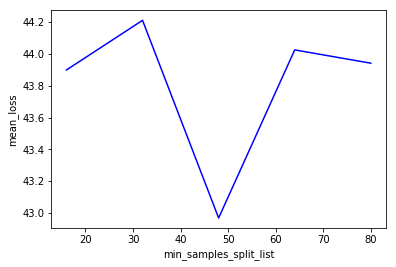

48 42.96893443012151


In [54]:
fold = KFold(n_splits=5, shuffle=False, random_state=0) 
mean_loss = []
min_samples_split_list = []
for i in [16, 32, 48, 64, 80]:
    loss_list = []
    for k, (train, test) in enumerate(fold.split(X_undersample_train_gbt, y_undersample_train_gbt)):
        gbt = GradientBoostingClassifier(n_estimators=300, max_depth=5, min_samples_split=i, random_state=0)
        loss = custom_loss_fuction(gbt, X_undersample_train_gbt.iloc[train], X_test_gbt, y_undersample_train_gbt.iloc[train], y_test_gbt)
        loss_list.append(loss)
    mean_loss.append(np.mean(loss_list))
    min_samples_split_list.append(i)
plt.plot(min_samples_split_list, mean_loss, '-b')
plt.ylabel('mean_loss')
plt.xlabel('min_samples_split_list')
plt.show()

min_loss = np.min(mean_loss)
min_loss_index = mean_loss.index(min_loss)
optimal_min_samples_split = min_samples_split_list[min_loss_index]
print optimal_min_samples_split, min_loss

#### So far, we got optimal n_estimators=300, max_depth=5, min_samples_split=48.
#### Tuning subsample and making models with lower learning rate.
***

In [55]:
def Kfold_tuning_gbt1(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    subsample_range = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
    subsample_list = []
    mean_loss_list = []

    j = 0
    for subsample in subsample_range:
        print '-------------------------------------------'
        print 'subsample: ', subsample
        print '-------------------------------------------'
        loss_list = []
        for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

            gbt = GradientBoostingClassifier(n_estimators=300,max_depth=5, min_samples_split=48, subsample=subsample, random_state=0)

            loss = custom_loss_fuction(gbt, X_train_data.iloc[train], X_test_gbt, y_train_data.iloc[train], y_test_gbt)
            loss_list.append(loss)
            print 'Fold ', k + 1,': loss = ', loss

        j += 1
        print ''
        print 'Mean loss', np.mean(loss_list)
        print ''
        subsample_list.append(subsample)
        mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['Subsample','Mean loss'])
    results_table['Subsample'] = subsample_list
    results_table['Mean loss'] = mean_loss_list

    best_subsample = results_table.loc[results_table['Mean loss'].idxmin()]['Subsample']

    print results_table
    print  ''

    print '*******************************************************************'
    print "Best model to choose from cross validation is with subsample = ", best_subsample
    print '*******************************************************************'

    return Kfold_tuning_gbt1

In [56]:
best_parameters_gbt1 = Kfold_tuning_gbt1(X_undersample_train_gbt, y_undersample_train_gbt)

-------------------------------------------
subsample:  0.6
-------------------------------------------
Fold  1 : loss =  97.05728418287352
Fold  2 : loss =  80.71442188132289
Fold  3 : loss =  71.44273769627009
Fold  4 : loss =  119.66814811655114
Fold  5 : loss =  97.06228998643448

Mean loss 93.18897637269042

-------------------------------------------
subsample:  0.65
-------------------------------------------
Fold  1 : loss =  73.47108818011257
Fold  2 : loss =  154.97790708355305
Fold  3 : loss =  50.998248337028826
Fold  4 : loss =  74.79161707317073
Fold  5 : loss =  81.13679255179649

Mean loss 87.07513064513232

-------------------------------------------
subsample:  0.7
-------------------------------------------
Fold  1 : loss =  100.25728214568068
Fold  2 : loss =  46.05305279106385
Fold  3 : loss =  80.8283479759375
Fold  4 : loss =  97.83547902776259
Fold  5 : loss =  70.27910106794

Mean loss 79.05065260167693

-------------------------------------------
subsample:  0

#### When subsample = 0.9, the mean loss is 53.46 which is larger than the one(42.97) with subsample=1(default). Thus, the optimal subsample=default(1.0).
***

In [58]:
def Kfold_tuning_gbt2(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    learning_rate_range = [0.1, 0.05, 0.01, 0.005]
    n_estimators_range = [300, 600, 3000, 6000]
    mean_loss_list = []

    j = 0
    for i in range(0,4):
        print '-------------------------------------------'
        print 'learning_rate: ', learning_rate_range[i]
        print 'n_estimators: ', n_estimators_range[i]
        print '-------------------------------------------'
        loss_list = []
        for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

            gbt = GradientBoostingClassifier(learning_rate=learning_rate_range[i], n_estimators=n_estimators_range[i],max_depth=5, min_samples_split=48, random_state=0)

            loss = custom_loss_fuction(gbt, X_train_data.iloc[train], X_test_gbt, y_train_data.iloc[train], y_test_gbt)
            loss_list.append(loss)
            print 'Fold ', k + 1,': loss = ', loss

        j += 1
        print ''
        print 'Mean loss', np.mean(loss_list)
        print ''
        mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['Learning_rate', 'N_estimators', 'Mean loss'])
    results_table['Learning_rate'] = learning_rate_range
    results_table['N_estimators'] = n_estimators_range
    results_table['Mean loss'] = mean_loss_list
    
    best_learning_rate = results_table.loc[results_table['Mean loss'].idxmin()]['Learning_rate']
    best_n_estimators = results_table.loc[results_table['Mean loss'].idxmin()]['N_estimators']

    print results_table
    print  ''

    print "***************************************************************************"
    print "Best model to choose from cross validation is with best learning rate = ", best_learning_rate,
    print "and corresponding n_estimators = ", best_n_estimators
    print "***************************************************************************"

    return Kfold_tuning_gbt2

In [59]:
best_parameters_gbt2 = Kfold_tuning_gbt2(X_undersample_train_gbt, y_undersample_train_gbt)

-------------------------------------------
learning_rate:  0.1
n_estimators:  300
-------------------------------------------
Fold  1 : loss =  43.641858704793954
Fold  2 : loss =  42.71008949474312
Fold  3 : loss =  45.23431593779779
Fold  4 : loss =  41.781050904763504
Fold  5 : loss =  41.477357108509196

Mean loss 42.96893443012151

-------------------------------------------
learning_rate:  0.05
n_estimators:  600
-------------------------------------------
Fold  1 : loss =  41.275524714787075
Fold  2 : loss =  39.24052428889941
Fold  3 : loss =  44.52856043086348
Fold  4 : loss =  41.386164541118355
Fold  5 : loss =  36.175752395470376

Mean loss 40.521305274227736

-------------------------------------------
learning_rate:  0.01
n_estimators:  3000
-------------------------------------------
Fold  1 : loss =  32.01255554713932
Fold  2 : loss =  31.19523386847793
Fold  3 : loss =  30.652787195448195
Fold  4 : loss =  28.2118383795907
Fold  5 : loss =  32.58628181749107

Mean los

#### Optimal GBT Model
* leanring_rate = 0.005, n_estimators = 6000, max_depth=5, min_samples_split=48; subsample equals to default.
* Though keep decresing the learning rate might give us a better result, the slow learning rate will consume a lot of time and will not improve the model performance quite much. Even 0.005 will slow down the calculation here. Thus, the learning rate smaller than 0.005 will not be discussed in this project.
***

the model classification for 116 proportion
the recall for this model is : 0.9613821138211383
The accuracy is : 0.999515461347509
TP 473
TN 284196
FP 119
FN 19


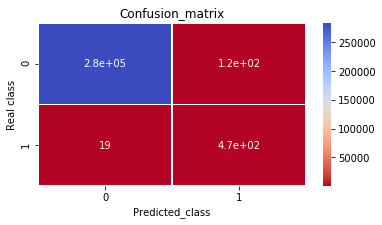

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.80      0.96      0.87       492

avg / total       1.00      1.00      1.00    284807

The loss is :  22.463499368270703


In [60]:
print "the model classification for 116 proportion"
optimal_gbt = GradientBoostingClassifier(learning_rate=0.005, n_estimators=6000, max_depth=5, min_samples_split=48, random_state=0)
prediction_algorithms(optimal_gbt, X_undersample_train_gbt, X_test_gbt, y_undersample_train_gbt, y_test_gbt)

## Conclusion of model selection
***

#### Model performances without resampling, pre-precessing or tunning hyperparameters:

|         Models         | Precision | Recall |  F1  | Accuracy | Custom Loss |
|:----------------------:|:---------:|:------:|:----:|:--------:|:-----------:|
|   Logistic Regression  |    0.81   |  0.60  | 0.69 |   0.99   |    65.62    |
| Support Vector Machine |    1.00   |  0.03  | 0.05 |   0.99   |    118.46   |
|      *Random Forest    |    0.94   |  0.75  | 0.83 |   0.99   |    35.83    | 
| Gradient Boosting Tree |    0.80   |  0.47  | 0.60 |   0.99   |    82.38   |

#### Optimal model performances after pre-processing and selection of optimal proportion:

* All the models perform better after selecting a appropriate proportion for undersampling especially for SVM and GBT.

* Random Forest is the best among the 4 models.

* Models in this part and the next part are trained on the undersampled dataset and tested on the WHOLE DATA SET. Thus, the performances here might be worse than the 1st part.

|         Models         | Precision | Recall |  F1  | Accuracy | Custom Loss | Diff vs 1st table |
|:----------------------:|:---------:|:------:|:----:|:--------:|:-----------:|:-----------------:|
|   Logistic Regression  |    0.60   |  0.51  | 0.55 |   0.99   |    95.15    |        29.53      |
| Support Vector Machine |    1.00   |  0.77  | 0.87 |   0.99   |    28.09    |       -90.37      |
|      *Random Forest    |    0.82   |  0.96  | 0.88 |   0.99   |    20.78    |       -15.05      |
| Gradient Boosting Tree |    0.68   |  0.93  | 0.79 |   0.99   |    36.80    |       -45.58      |

#### Optimal model performances after tunning hyperparameters:

* All the models have got improvements from hyperparameters' tunning especially for Logistic Regression and Gradient Boosting Tree.

* In conclusion, SVM and Random Forest are more sensitive to the proportion of undersampling compared to tunning hyperparameters. Logistic Reregssion and GBT are sensetive to both of them.

* Random Forest is still the best amoung the 4 models. Actually the improvement after tunning hyperparameters is trivial for Support Vector Machine (non-linear) and Random Forest. Anyway, better than nothing. It still saves about $ 1.09 per (fraud + misclassification normal) transaction for us.

* SVM has a 100% precision which means if a transaction is classified as fraud by SVM then it must be a fraud. Thus, a typical predication process would be like this: predict using SVM first, if result is fraud then classify the transaction as fraud. Otherwise, predict agian using Random Forest and return the prediction result. By doing this, we could increase the recall rate as far as possible without doing any harm to precision.

* The optimal SVM and Random Forest models are:
> SVC(C=1, gamma=0.1)
<br>RandomForestClassifier(n_estimators=200, max_features=1, max_depth=20, min_smaples_split=2, min_samples_leaf=1)
    

|         Models         | Precision | Recall |  F1  | Accuracy | Custom Loss | Diff vs 1st table | Diff vs 2nd table |
|:----------------------:|:---------:|:------:|:----:|:--------:|:-----------:|:-----------------:|:-----------------:|
|   Logistic Regression  |    0.79   |  0.78  | 0.79 |   0.99   |    45.41    |       -20.21      |       -49.74      |
| *Support Vector Machine|    1.00   |  0.78  | 0.88 |   0.99   |    26.87    |       -91.59      |       -1.22       |
|      *Random Forest    |    0.86   |  0.94  | 0.90 |   0.99   |    19.69    |       -16.14      |       -1.09       |
| Gradient Boosting Tree |    0.80   |  0.96  | 0.87 |   0.99   |    22.54    |       -59.84      |       -14.26      |
